<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Handwritten Documents

## Imports
Dependencies needed to run the code, including mounting GoogleDrive and copying files.

In [8]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

# Python
import gc
import os
import gzip
import tarfile
import time

# Data Structures
import pandas as pd
import numpy as np
import json
import csv

# Debug/Progress
from tqdm import tqdm
import pdb
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

# Image Manipulations / Plotting
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

# Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "drive/My Drive/datasets/iam-line-level.zip" "/content"
!cp "drive/My Drive/datasets/rimes-line-level.zip" "/content"
!unzip -q iam-line-level.zip -d iam
!unzip -q rimes-line-level.zip -d rimes
!rm iam-line-level.zip
!rm rimes-line-level.zip
!wget -q https://raw.githubusercontent.com/ericburdett/cs601r-dl/master/char_set.json

### Create IAM and RIMES Dataset Classes

In [0]:
class IamDataset(Dataset):
  def __init__(self, desired_size=(256,32)):
    self.desired_size = desired_size
    self.img_path = '/content/iam/images/'
    self.df = pd.read_csv('/content/iam/labels.csv', header=None, sep='\t', names=['img', 'transcription'], quoting=csv.QUOTE_NONE)

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    # Resize here if needed
    x = transforms.functional.to_tensor(img)

    return x

  def __getitem__(self, index):
    path = 'iam/images/' + self.df['img'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)

Transcription:  assuredness "Bella Bella Marie" (Parlophone), a lively song that changes tempo mid-way. 



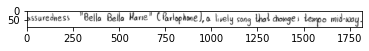

In [117]:
index = 3284
dataset = IamDataset()

print('Transcription: ', dataset[index][1], '\n')
plt.imshow(dataset[index][0].squeeze(), cmap='gray')

In [115]:
longest = 0
longest_str = ''
longest_idx = 0

for i in range(len(dataset)):
  if len(dataset[i][1]) > longest:
    longest = len(dataset[i][1])
    longest_str = dataset[i][1]
    longest_idx = i

print(longest)
print(longest_str)
print(longest_idx)

87
assuredness "Bella Bella Marie" (Parlophone), a lively song that changes tempo mid-way.
3284


In [0]:
class RimesDataset(Dataset):
  def __init__(self, desired_size=(256,32)):
    self.desired_size = desired_size
    self.img_path = '/content/rimes/images/'
    self.df = pd.read_csv('/content/rimes/labels.csv', header=None, sep='\t', names=['img', 'transcription'], quoting=csv.QUOTE_NONE)

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path)
    # Resize here if needed
    x = transforms.functional.to_tensor(img)

    return x

  def __getitem__(self, index):
    path = 'rimes/images/' + self.df['img'][index]
    img = self.tensor_image(path)

    return img, str(self.df['transcription'][index])
  
  def __len__(self):
    return len(self.df)

Transcription:   établit  à la suite de  cette  accident, mentionnant les faits, les dégâts et les tiers concernés. 



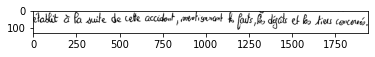

In [147]:
index = 7769
dataset = RimesDataset()

print('Transcription: ', dataset[index][1], '\n')
plt.imshow(dataset[index][0].squeeze(), cmap='gray')

In [146]:
longest = 0
longest_str = ''
longest_idx = 0

for i in range(len(dataset)):
  if len(dataset[i][1]) > longest:
    longest = len(dataset[i][1])
    longest_str = dataset[i][1]
    longest_idx = i

print(longest)
print(longest_str)
print(longest_idx)

99
 établit  à la suite de  cette  accident, mentionnant les faits, les dégâts et les tiers concernés.
7769


### Character Encoding

In [0]:
class Encoder():
  def __init__(self, sequence_size=150):
    with open('char_set.json') as file:
      self.json = json.load(file)
    
    self.sequence_size = sequence_size

  def remove_duplicates(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      if i + 1 == len(idxs) or idxs[i] != idxs[i + 1]:
        new_idxs.append(idxs[i])
    
    return new_idxs
  
  def add_blanks(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      new_idxs.append(idxs[i])
      if i + 1 != len(idxs) and idxs[i] == idxs[i + 1]:
        new_idxs.append(0)
    
    return new_idxs
  
  def idx_to_char(self, idx):
    if idx == 0:
      return ''
    else:
      return self.json['idx_to_char'][str(int(idx))]
  
  def char_to_idx(self, char):
    return int(self.json['char_to_idx'][char])
  
  def str_to_idxs(self, string):
    idxs = []

    zeros = np.zeros(self.sequence_size)

    for char in string:
      idxs.append(self.char_to_idx(char))

    # Add blanks if CTC-Loss requires it...
    # idxs = self.add_blanks(idxs)

    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]
    
    return idxs, len(string)

  def idxs_to_str(self, idxs):
    string = ''
    idxs = self.remove_duplicates(idxs)

    for idx in idxs:
      string += self.idx_to_char(idx)
    
    return string
  
  def str_to_idxs_batch(self, batch):
    idxs = []
    lengths = []

    for string in batch:
      idx, length = self.str_to_idxs(string)
      idxs.append(idx)
      lengths.append(length)
    
    return idxs, lengths
  
  def idxs_to_str_batch(self, batch):
    strings = []

    for idxs in batch:
      strings.append(self.idxs_to_str(idxs))
    
    return strings

### Model

In [0]:
class Recognizer(nn.Module):
  def __init__(self, sequence_length=16, language_size=197, hidden_size=256, num_layers=2, dropout_rate=0.2):
    super(Recognizer, self).__init__()

    self.language_size = language_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # Encoder
    self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(8))
    self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(16))
    self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(32))
    self.conv4 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(64))
    self.conv5 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(128))
    self.conv6 = nn.Sequential(nn.Conv2d(128, language_size, 3, 1, 1), nn.LeakyReLU(), nn.BatchNorm2d(language_size))

    self.gate1 = nn.Sequential(nn.Conv2d(8, 8, 3, 1, 1), nn.Sigmoid())
    self.gate2 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate3 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate4 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())
    self.gate5 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.Sigmoid())

    self.drop1 = nn.Dropout2d(p=dropout_rate)
    self.drop2 = nn.Dropout2d(p=dropout_rate)
    self.drop3 = nn.Dropout2d(p=dropout_rate)
    self.drop4 = nn.Dropout2d(p=dropout_rate)
    self.drop5 = nn.Dropout2d(p=dropout_rate)

    # Maxpool
    self.mp = nn.MaxPool2d((32, 1))

    # Decoder
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, sequence_length)
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    return torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)

  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    gate1 = self.gate1(out)
    out = out * gate1
    out = self.drop1(out)

    out = self.conv2(out)
    gate2 = self.gate2(out)
    out = out * gate2
    out = self.drop2(out)

    out = self.conv3(out)
    gate3 = self.gate3(out)
    out = out * gate3
    out = self.drop3(out)

    out = self.conv4(out)
    gate4 = self.gate4(out)
    out = out * gate4
    out = self.drop4(out)

    out = self.conv5(out)
    gate5 = self.gate5(out)
    out = out * gate5
    out = self.drop5(out)

    out = self.conv6(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.view(-1, self.language_size, 128)

    out, _ = self.gru1(out)
    out = self.fc1(out)
    out, _ = self.gru2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out

In [0]:
def parameter_count(model):
  return sum(p.numel() for p in model.parameters())

In [53]:
recognizer = Recognizer(sequence_length=150, num_layers=1)
print('param count: ', parameter_count(recognizer))
print('out size: ', recognizer(torch.randn(1, 1, 32, 128)).shape)

param count:  1851341
out size:  torch.Size([150, 1, 197])


### Rimes Training

In [0]:
def train(dataset):
  EPOCHS = 50
  BATCH_SIZE = 250
  ITERATION_SAMPLE = 100

  extra_num = 0 if len(dataset) % 2 == 0 else 1

  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(.8 * len(dataset)) + extra_num, int(.2 * len(dataset))])
  
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

  encoder = Encoder()
  recognizer = Recognizer(sequence_length=150, language_size=197, hidden_size=256, num_layers=1, dropout_rate=0.2)
  optimizer = optim.Adam(recognizer.parameters(), lr=5e-4)
  objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)

  train_losses = []
  val_losses = []

  for epoch in range(EPOCHS):
    loop = tqdm(total=len(train_loader), position=0, leave=False)

    # Training Loop
    for batch_num, (imgs, words) in enumerate(train_loader):
      batch_size = imgs.shape[0]

      idxs, word_lengths = encoder.str_to_idx_batch(words)

      imgs, labels = imgs.cuda(), torch.tensor(idxs).cuda()

      optimizer.zero_grad()

      input_lengths = torch.full((batch_size,), 16, dtype=torch.long).cuda()
      target_lengths = torch.tensor(word_lengths).cuda()

      preds = recognizer(imgs)

      loss = objective(preds, labels, input_lengths, target_lengths)
      loss = torch.mean(loss)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      if batch_num % ITERATION_SAMPLE == 0:
        preds_strings = encoder.idxs_to_str_batch(preds.permute(1, 0, 2).argmax(dim=2))
        print('\nTargets: ', words[:3])
        print('Predicted: ', preds_strings[:3])
        show_imgs(imgs[:3])
        plt.pause(1)

      loop.set_description('Epoch: {}, Loss: {:.4f}, AvgLoss: {:.4f}'.format(epoch, loss.item(), np.mean(train_losses)))
      loop.update(1)
    
    loop.close()